In [153]:
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import learning_curve, validation_curve, cross_val_score, train_test_split, KFold, GridSearchCV

from plotting import Plotting
from cholesky import Cholesky
from lasso import Lasso

column_to_predict = 'median_house_value'
categories_columns = ['ocean_proximity']
numerics_columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]



In [154]:
data_frame = pandas.read_csv(filepath_or_buffer='cal-housing.csv')

outliers = data_frame[data_frame[column_to_predict] == 500001].index

print(f'There are {len(outliers)} outliers')

data_frame.drop(outliers, inplace=True)

for c in data_frame.columns:
    if data_frame[c].hasnans:
        m = data_frame[c].mean()
        data_frame[c].fillna(value=m, inplace=True)
        
useLabelEncoder = False

if useLabelEncoder:
    labelencoder = LabelEncoder()

    for c in categories_columns:
        c_name = c + '_cat'
        data_frame[c_name] = labelencoder.fit_transform(data_frame[c])
        numerics_columns.append(c_name)

    data_frame.drop(columns=categories_columns, inplace=True)    
else:
    data_frame['ocean_proximity'].replace(['INLAND', '<1H OCEAN', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND'], [1, 10, 50, 100, 500], inplace=True)
    numerics_columns.append('ocean_proximity')

data_frameOriginal = data_frame.copy(deep=True)  

columns_to_remove = []
columns_to_use = list(data_frame.columns)

for u in columns_to_remove:
    columns_to_use.remove(u)
    if numerics_columns.count(u) > 0:
        numerics_columns.remove(u)
        
data_frame.drop(columns=columns_to_remove, inplace=True)

X = data_frame[numerics_columns]
y = data_frame[column_to_predict]

useMinMaxScaler = True
if useMinMaxScaler:
    column_to_predict_idx = data_frame.columns.get_loc(column_to_predict)
    cols = list(range(0, data_frame.shape[1]))
    cols.remove(column_to_predict_idx)

    scaler = MinMaxScaler()
    scaler.fit(data_frame)
    data_frame = scaler.transform(data_frame)    
    
data_frame = pandas.DataFrame(data_frame, columns=columns_to_use)

X = data_frame[numerics_columns]
y = data_frame[column_to_predict]



There are 965 outliers


In [155]:
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,0.211155,0.567481,0.784314,0.022331,0.019711,0.008941,0.020395,0.539668,0.198397
1,0.212151,0.565356,0.392157,0.180503,0.171349,0.067210,0.186842,0.538027,0.198397
2,0.210159,0.564293,1.000000,0.037260,0.029179,0.013818,0.028783,0.466028,0.198397
3,0.209163,0.564293,1.000000,0.032352,0.036163,0.015555,0.035691,0.354699,0.198397
4,0.209163,0.564293,1.000000,0.041330,0.043148,0.015752,0.042270,0.230776,0.198397
...,...,...,...,...,...,...,...,...,...
19670,0.324701,0.737513,0.470588,0.042296,0.057737,0.023599,0.053947,0.073130,0.000000
19671,0.312749,0.738576,0.333333,0.017676,0.022971,0.009894,0.018421,0.141853,0.000000
19672,0.311753,0.732200,0.313725,0.057277,0.074965,0.028140,0.070888,0.082764,0.000000
19673,0.301793,0.732200,0.333333,0.047256,0.063169,0.020684,0.057072,0.094295,0.000000


In [156]:
y

0        0.902268
1        0.708248
2        0.695052
3        0.672784
4        0.674640
           ...   
19670    0.130105
19671    0.128043
19672    0.159383
19673    0.143713
19674    0.153404
Name: median_house_value, Length: 19675, dtype: float64

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)


In [158]:
min_ts = int(X.shape[0] * 0.3)
max_ts = int(X.shape[0] * 0.8)
step_ts = int(X.shape[0] * 0.1)
sizes = range(min_ts, max_ts, step_ts)

print(sizes)

range(5902, 15740, 1967)


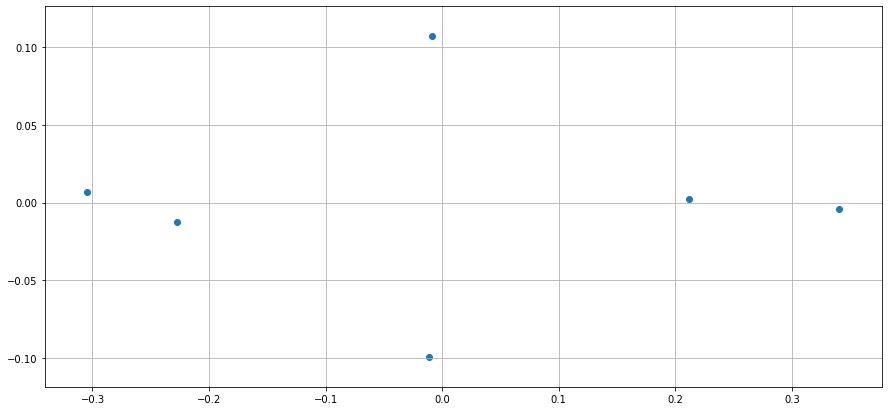

In [159]:
coef_pca = cholesky.fitPCABySize(sizes, X, y, 2)
Plotting.scatterPlot(coef_pca[:,0], coef_pca[:,1])

In [178]:
X_pca = cholesky.fitPCA(X.shape[1], X)

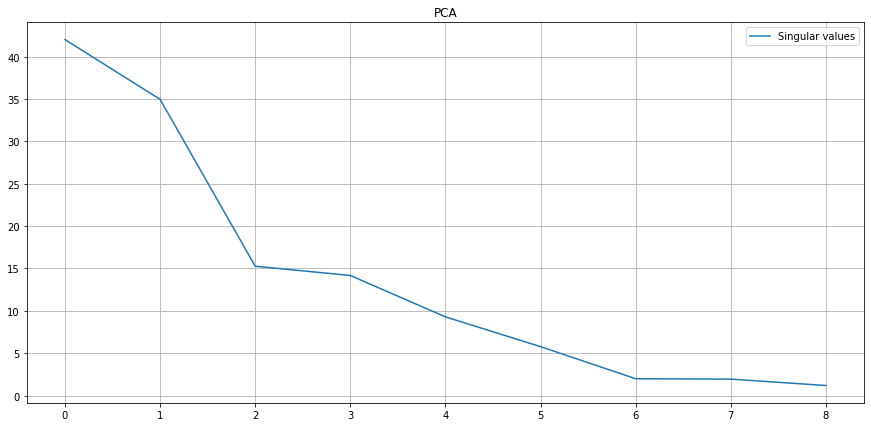

In [179]:
Plotting.plot('PCA', cholesky.pca_singular_values, 'Singular values')

In [162]:
RMS = 'neg_mean_squared_error'
R2 = 'r2'

#scoring = R2
#scoring_neg = 1
#scoring_label = 'R²'

scoring = RMS
scoring_neg = -1
scoring_label = 'MSE'

nested_cross_validation_trials = 10

useMinMaxScaler = True

fit_intercept = True
normalize = True

In [175]:
#aggiunto transform (?) si deve fare? 
X_pca = cholesky.fitPCA(8, X)

X_pca = pca.transform(X)

train_size, train_score, val_score = learning_curve(cholesky, X_pca, y, train_sizes=sizes, cv=5, scoring=RMS, n_jobs=-1)


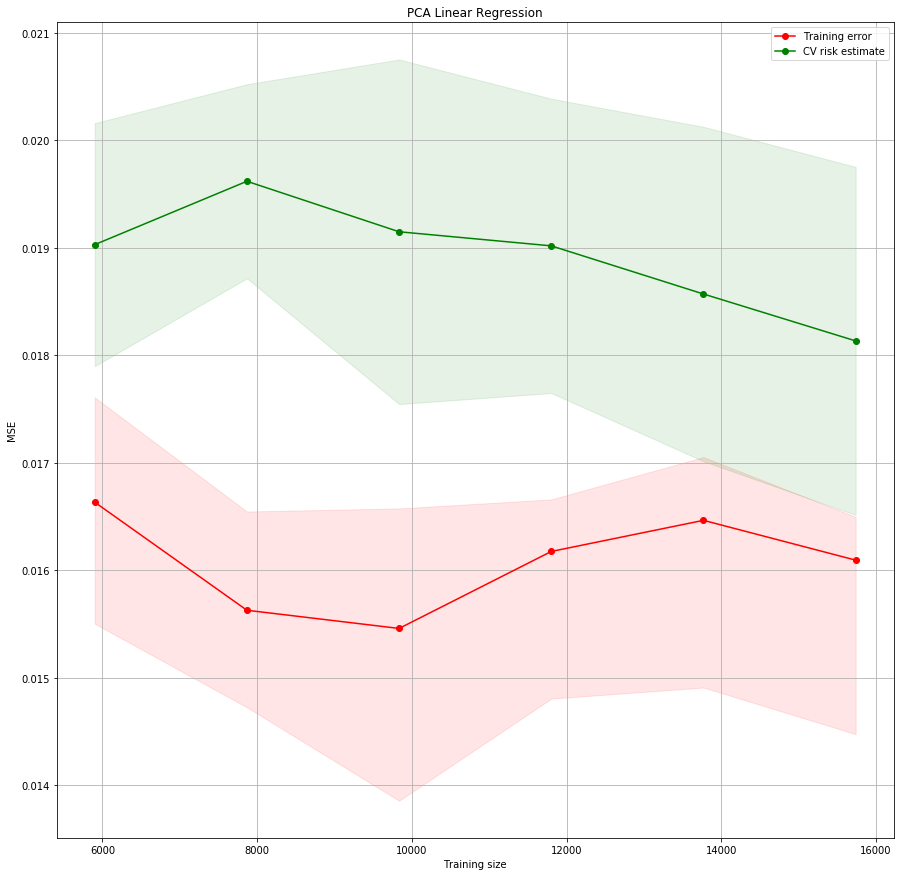

In [176]:
Plotting.plotAreaMeanStd(
	'PCA Linear Regression', 
	sizes, 
	[train_score, val_score], 	
    True,
	['Training error', 'CV risk estimate'],
	['r', 'g'],
	'Training size',
	'MSE')

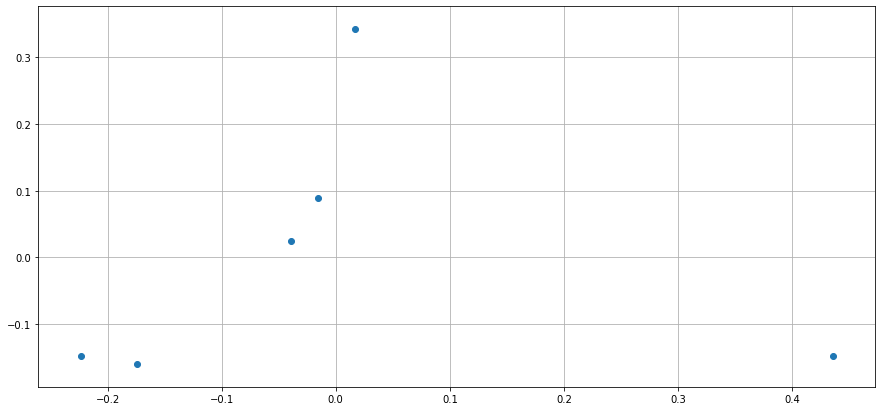

In [165]:
coef_pca = cholesky.fitPCABySize(sizes, X_pca, y, 2)
Plotting.scatterPlot(coef_pca[:,0], coef_pca[:,1])

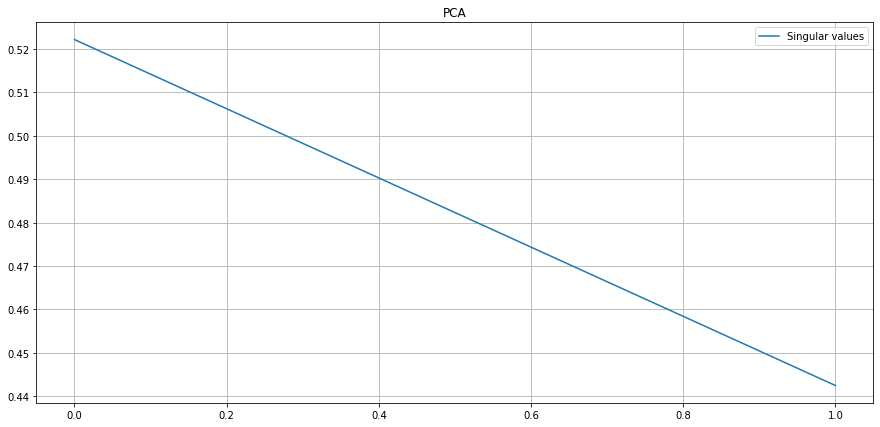

In [166]:
Plotting.plot('PCA', cholesky.pca_singular_values, 'Singular values')

In [167]:
train_size, train_score, val_score = cholesky.learningCurvePCA(sizes, 5, X, y, scoring)

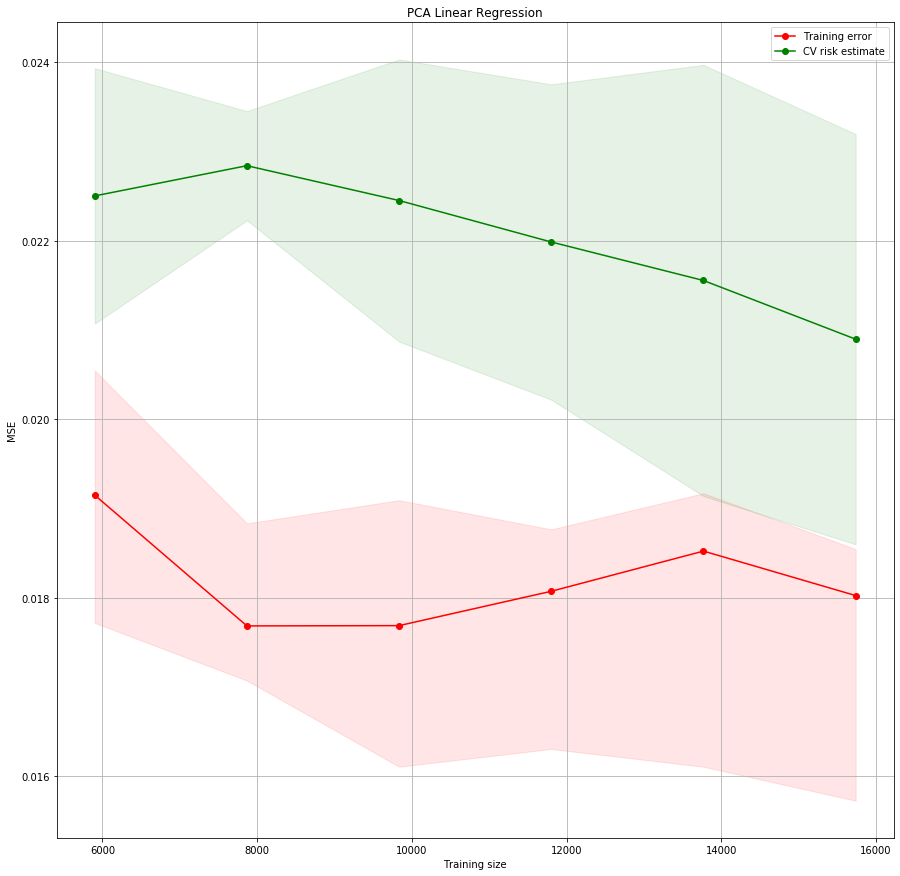

In [168]:
Plotting.plotAreaMeanStd(
    'PCA Linear Regression',
    sizes,
    [train_score, val_score],
    True,
    ['Training error', 'CV risk estimate'],
    ['r', 'g'],
    'Training size',
    'MSE')

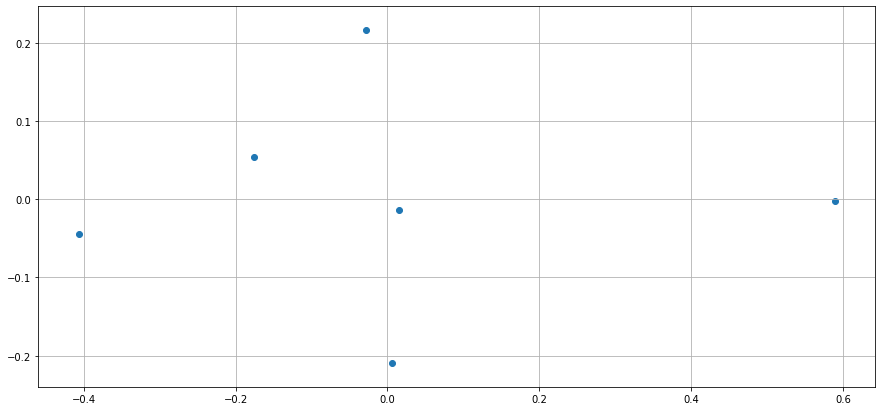

In [169]:
#Questo è tipo con due componenti(?)
coef_pca = cholesky.fitPCABySize(sizes, X_pca, y, 2)
Plotting.scatterPlot(coef_pca[:,0], coef_pca[:,1])

cholesky = Cholesky()
cholesky.fit(X_train, y_train)
numpy.round(cholesky.coef_[0], decimals=2)

coef_list = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
cholesky.fit(X_train, y_train)
coef_list.append(cholesky.coef_)
#coef_matrix = numpy.array(coef_list)

coef_list_1 = pandas.Series(coef_list * 100)

In [170]:
#coef_matrix

In [171]:
#pandas.Series(coef_list * 100)

In [172]:
#from sklearn import decomposition

#pca = decomposition.PCA(n_components=2)
#pca.fit(coef_list)
#coef_pca = pca.transform(coef_list)#

fig, ax = plt.subplots()
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-0.5, 0.5)
plt.scatter(coef_pca[:,0], coef_pca[:,1])

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

pandas.Series(pca.explained_variance_ratio_ * 100)

0    49.664320
1    34.564275
2     6.542653
3     5.585325
4     2.438385
5     0.947874
6     0.111252
7     0.105673
8     0.040244
dtype: float64

In [174]:
alphas = numpy.sort(numpy.linspace(1, 0, 20, False))

for C in range(1, 10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    pandas.DataFrame(X_train)
    pca = PCA(n_components=C)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    pandas.Series(pca.explained_variance_ratio_ * 100)

    cholesky = Cholesky()
    cholesky.calculateScoring(alphas, X_train, y_train, X_test, y_test)
    print('Componenti', C)
    cholesky.printBestScores()

Componenti 1
Cholesky:
-best ɑ: 0.04999999999999993
-best MSE: 0.040027732312433596
-best R²: 0.004161182048356138
Componenti 2
Cholesky:
-best ɑ: 0.04999999999999993
-best MSE: 0.03924688698233002
-best R²: 0.0057726667046752445
Componenti 3
Cholesky:
-best ɑ: 0.04999999999999993
-best MSE: 0.01914192606334123
-best R²: 0.5219036993384227
Componenti 4
Cholesky:
-best ɑ: 0.19999999999999996
-best MSE: 0.01882815357336518
-best R²: 0.5136198435672843
Componenti 5
Cholesky:
-best ɑ: 0.1499999999999999
-best MSE: 0.018499485890954716
-best R²: 0.5369860051274066
Componenti 6
Cholesky:
-best ɑ: 0.04999999999999993
-best MSE: 0.01728354166677948
-best R²: 0.5772824641582006
Componenti 7
Cholesky:
-best ɑ: 0.04999999999999993
-best MSE: 0.017535840886916034
-best R²: 0.578530929089308
Componenti 8
Cholesky:
-best ɑ: 0.04999999999999993
-best MSE: 0.015794781350021783
-best R²: 0.605876764548461
Componenti 9
Cholesky:
-best ɑ: 0.04999999999999993
-best MSE: 0.01621546353798101
-best R²: 0.607